- 하위 수준 명령을 사용하여 기본 백업을 만드는 표준 절차

1. pg_backup_start 명령(버전 14 이하, pg_start_backup)을 실행.

2. 원하는 아카이브 명령을 사용하여 데이터베이스 클러스터의 스냅샷을 찍음.

3. pg_backup_stop 명령(버전 14 이하, pg_stop_backup)을 실행.

- 이 간단한 절차는 cp 명령이나 유사한 보관 도구와 같은 일반적인 도구 외에 특별한 도구가 필요하지 않기 때문에 데이터베이스 관리자가 쉽게 사용할 수 있음.
- 이 절차에는 테이블 잠금이 필요하지 않으므로 모든 사용자가 백업 작업의 영향을 받지 않고 계속해서 쿼리를 실행할 수 있음.
- 이는 다른 주요 오픈 소스 RDBMS에 비해 상당한 이점.

<BR>

- 기본 백업을 만드는 더 간단한 방법은 위에서 설명한 하위 수준 명령을 내부적으로 실행하는 pg_basebackup 유틸리티를 사용하는 것.

**Making a base backup.**

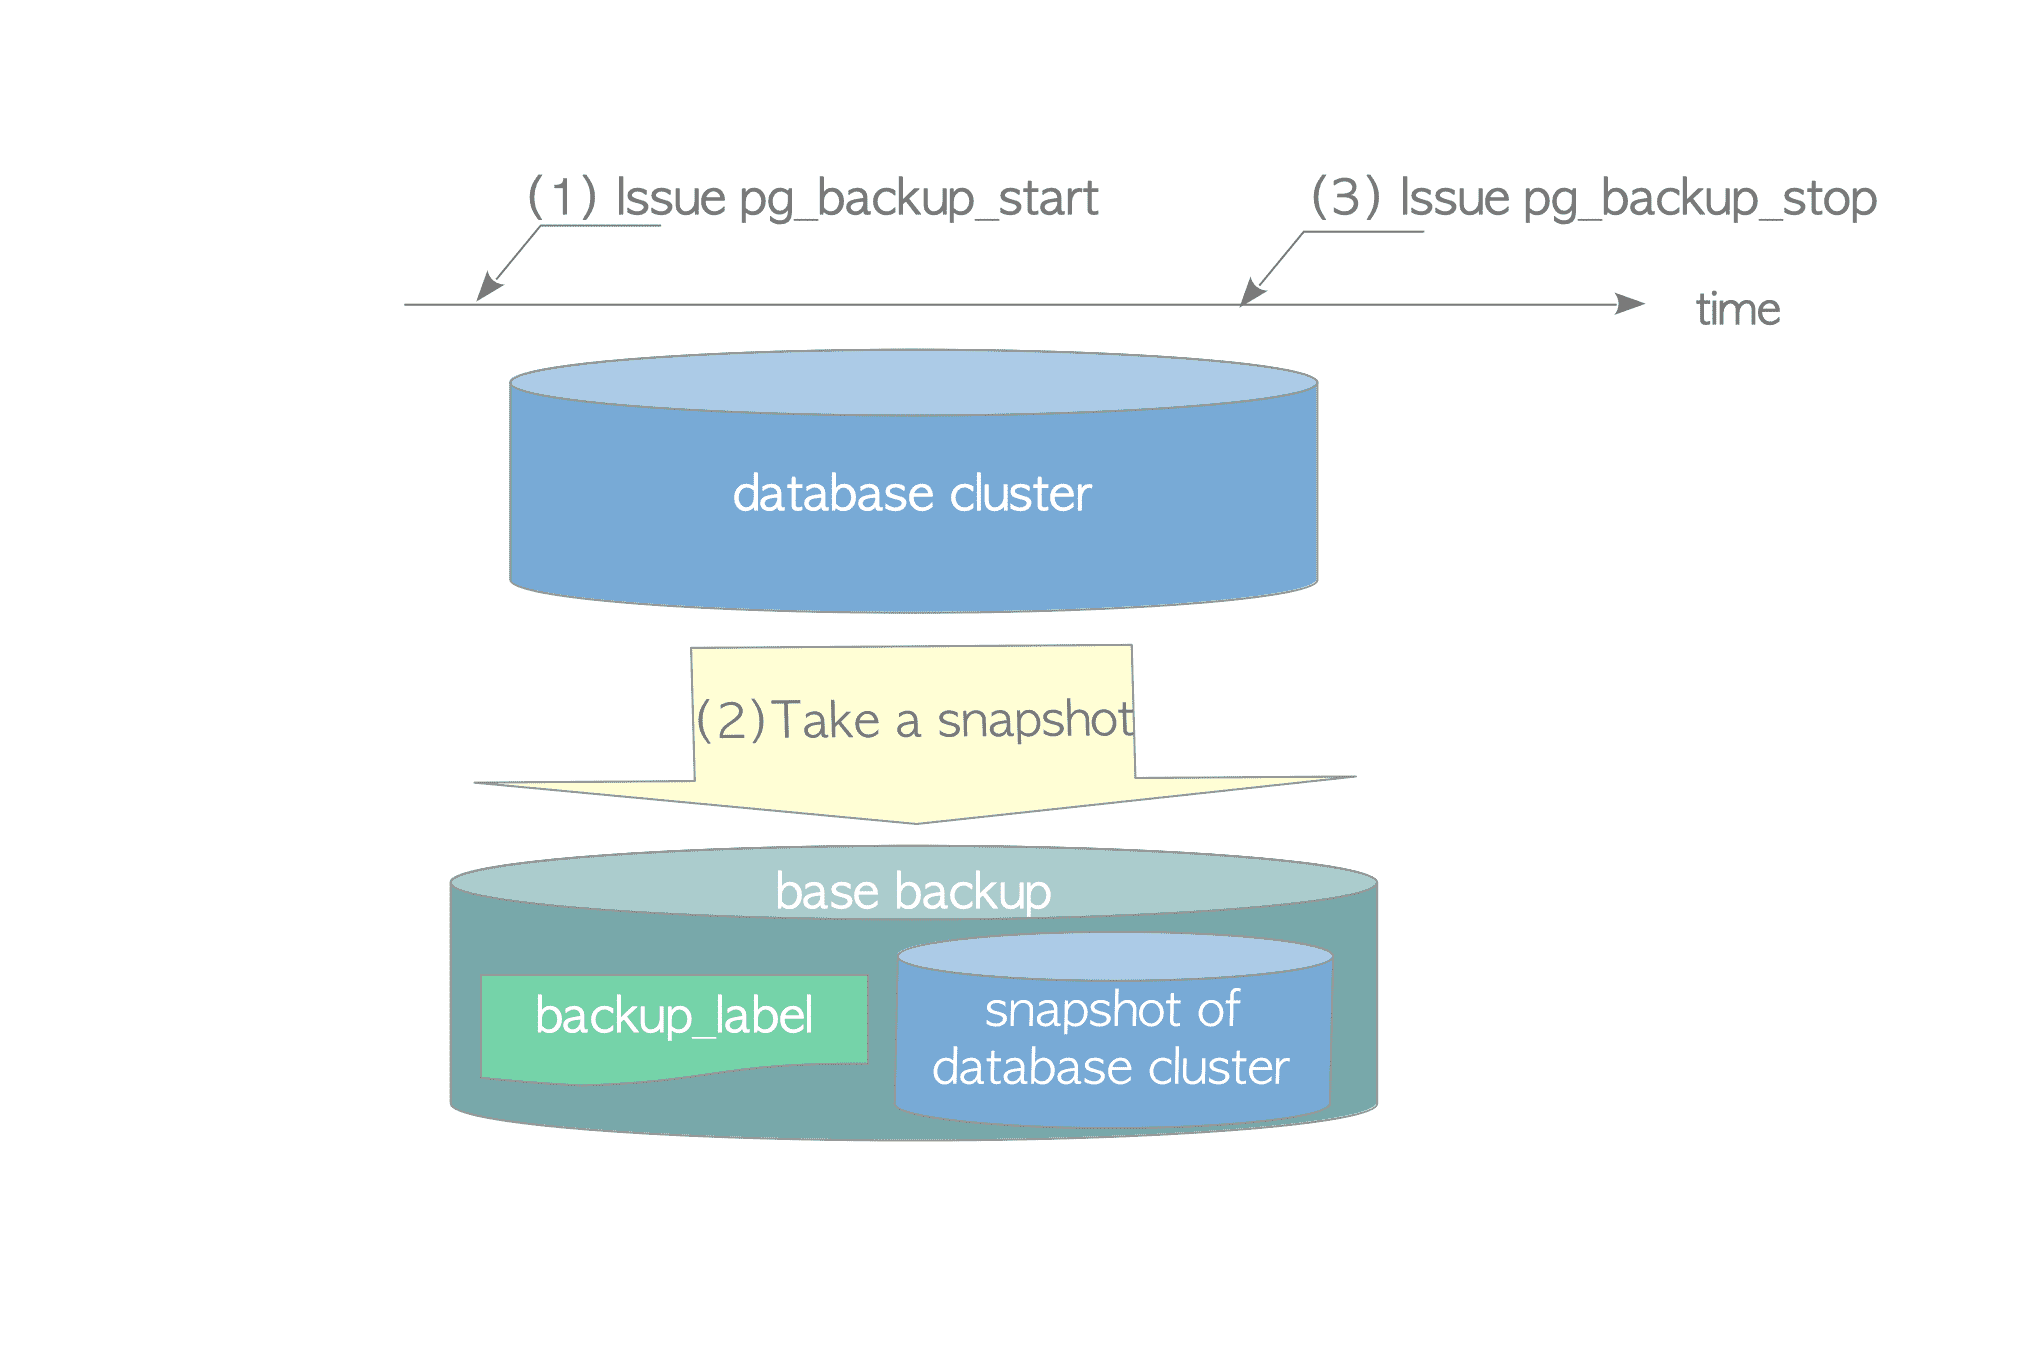

- pg_backup_start 및 pg_backup_stop 명령은 PITR을 이해하는 데 매우 중요하므로

**Info**

- pg_backup_start 및 pg_backup_stop 명령은 src/backend/access/transam/xlogfuncs.c 에 정의되어 있음.

# **pg_backup_start (Ver.14 or earlier, pg_start_backup)**

- pg_backup_start 명령은 기본 백업을 준비.

- 복구 프로세스는 REDO 지점에서 시작되므로 pg_backup_start 명령은 기본 백업 시작 시 REDO 지점을 명시적으로 생성하기 위해 체크포인트를 수행해야 함.
  - 또한 백업 중에 정기적인 체크포인트가 여러 번 수행될 수 있으므로 해당 체크포인트의 체크포인트 위치를 pg_control 이외의 파일에 저장해야 함.
  - 따라서 pg_backup_start는 다음 네 가지 작업을 수행함.

1. 데이터베이스를 전체 페이지 쓰기 모드로 강제 설정.

2. 현재 WAL 세그먼트 파일(버전 8.4 이상)로 전환.

3. 체크포인트를 시도.

4. backup_label 파일 생성
  - 기본 디렉터리의 최상위 수준에 생성되는 이 파일에는 이 체크포인트의 체크포인트 위치 등 기본 백업 자체에 대한 필수 정보가 포함되어 있음.

- 세 번째와 네 번째 작업이 이 명령의 핵심입니다
- 첫 번째와 두 번째 작업은 데이터베이스 클러스터를 보다 안정적으로 복구하기 위해 수행됨.

- backup_label 파일에는 다음 6개 항목(버전 11 이상, 7개 항목)이 포함되어 있음.

**CHECKPOINT LOCATION**
  - 이 명령으로 생성된 체크포인트가 기록된 LSN 위치.

**START WAL LOCATION**
  - 이는 PITR과 함께 사용되지 않지만 11장 에서 설명하는 스트리밍 복제와 함께 사용됨
  - 복제 모드의 대기 서버는 초기 시작 시 이 값을 한 번만 읽으므로 'START WAL LOCATION'이라는 이름이 붙었음.

**BACKUP METHOD**
  - 이 기본 백업을 만드는 데 사용되는 방법.

**BACKUP FROM**
  - 이 백업이 기본 서버 또는 대기 서버에서 수행되는지 여부를 표시.

**START TIME**
  - pg_backup_start 명령이 실행된 타임스탬프.

**LABEL**
  - pg_backup_start 명령에 지정된 레이블.

**START TIMELINE**
  - 백업이 시작된 타임라인.
  - 이는 온전성 검사를 위한 것이며 버전 11에서 도입됨.

<br>

**backup_label**

pg_basebackup을 사용하여 가져온 버전 16의 backup_label 파일의 실제 예는 다음과 같음.


```
postgres> cat /usr/local/pgsql/data/backup_label
START WAL LOCATION: 0/1B000028 (file 00000001000000000000001B)
CHECKPOINT LOCATION: 0/1B000060
BACKUP METHOD: streamed
BACKUP FROM: primary
START TIME: 2024-1-1 11:45:19 GMT
LABEL: pg_basebackup base backup
START TIMELINE: 1
```

- 이 기본 백업을 사용하여 데이터베이스를 복구하면 PostgreSQL은 backup_label 파일에서 'CHECKPOINT LOCATION'을 가져와 해당 아카이브 로그에서 체크포인트 레코드를 읽음.
- 그런 다음 레코드에서 REDO 지점을 가져오고 복구 프로세스를 시작

# **pg_backup_stop (Ver.14 or earlier, pg_stop_backup)**

- pg_backup_stop 명령은 다음 5가지 작업을 수행하여 백업을 완료.

1. pg_backup_start 명령에 의해 강제로 변경된 경우 전체 페이지가 아닌 쓰기 모드 로 재설정됨 .

2. 백업 종료 XLOG 레코드를 작성.

3. WAL 세그먼트 파일을 전환.

4. 백업 기록 파일을 만듦.
  - 이 파일에는 backup_label 파일의 내용과 pg_backup_stop 명령이 실행된 타임스탬프가 포함되어 있음.

5. backup_label 파일을 삭제.
  - backup_label 파일은 기본 백업에서 복구하는 데 필요하지만 일단 복사되면 원본 데이터베이스 클러스터에서는 필요하지 않음.

**Info**
- 백업 내역 파일의 이름 지정 방법은 다음과 같음.

```
{WAL segment}.{offset value at the time the base backup was started}.backup
```